This Jupyter Notebook file will be used to perform EDA and statistical exploration on important metrics and variables to draw deeper insights.

1. Dataset Loading and Formatting 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as datetime
import plotly
import matplotlib.ticker as mticker
import plotly.graph_objects as go


plt.style.use('ggplot')
sns.set_palette('husl')

#Load the dataset
df = pd.read_csv('eda_data.csv', on_bad_lines='skip')
if df is not None and not df.empty:
    print("DatFrame loaded successfully.")
else:
    print("Error.")
    
#format the invoice_date variable to datetime
df['invoice_date']=pd.to_datetime(df['invoice_date'])

#Format the use of non-scientific numbers in results and removing max rows/columns restrictions                                       
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


DatFrame loaded successfully.


2. Feature Engineering 

2.1. Separating Sales and Returns Events  

In [5]:
#slice df to focus on "sale" events
sales_df= df[df['transaction_type']=='sale']

#slice df to focus on "return" events
return_df = df[df['transaction_type'] == 'return']

2.2. Adding a new dataset feature "user_type" (binary: "customer" or "guests)

In [6]:
#Create column to distinguish "customer" and "guest"
df['user_type'] = np.where(df['customer_id'].notna(), 'customer', 'guest')


###not sure if I want to keep this for later

#########################
print(f"\nTotal Sales by Customers: ${df[(df['transaction_type'] == 'sale') & (df['user_type'] == 'customer')]['total'].sum():,.2f}")
print(f"\nTotal Sales by Guests: ${df[(df['transaction_type'] == 'sale') & (df['user_type'] == 'guest')]['total'].sum():,.2f}")

print(f"\nTotal Returns by Customers: ${df[(df['transaction_type'] == 'return') & (df['user_type'] == 'customer')]['total'].sum():,.2f}")
print(f"\nTotal Returns by Guests: ${df[(df['transaction_type'] == 'return') & (df['user_type'] == 'guest')]['total'].sum():,.2f}")




Total Sales by Customers: $8,911,105.30

Total Sales by Guests: $1,753,429.09

Total Returns by Customers: $-611,342.09

Total Returns by Guests: $-285,470.40


2.3. Aggregating and Simplifying "description" inputs. 

Having noticed that the dataset has 4193 unique responses for "description" I decided to investigate further.
I noticed two inneficiencies in this feature.
- Redudancy in inputs with similar meaning ("missing", "lost", "mia","find", etc).
- Different inputs for the same word. For example: "missing", "?missing","missing?", "?? missing" are all unique results which have the same meaning.

In [7]:
print("\nNumber of Unique descriptions: ")
print(df['description'].nunique())

example = df['description'].str.lower().str.contains('missing', na=False)
matching_descriptions = df.loc[example, 'description'].value_counts()
print(matching_descriptions)



Number of Unique descriptions: 
4193
description
missing        4
?missing       2
???missing     2
missing?       1
?? missing     1
????missing    1
Name: count, dtype: int64


That is why I decided to make groupings of these unique values to take better conclusions. 
To do so, I was forced to use the manual labelling process after atempting to use pre-trained language model like SentenceTransformer ("all-MiniLm" and "paraphrase-MiniLM") and "fuzzy matching", but I couldn't achieve the desired results and it falls outside the project focus (for now).

In [9]:
# I will start by defining the keyword sets
damaged_keywords = {'wet', 'crushed', 'damages?', 'damages/', 'damages', 'damaged', 'dagamed',
                    'breakages', 'broken', 'smashed', 'damage', 'mould', 'mouldy', 'cracked', 'faulty'}
adjustment_keywords = {'adjust', 'dotcom', 'postage', 'discount', 'amazon fee', 'amazon adjust', 
                      'amazon sold sets', 'bank charges', 're-adjustment', 'adjustment', 'sale error', 
                      'incorrectly credited c550456 see 47', 'did a credit and did not tick ret'}
missing_keywords = {'lost', '?', 'missing', 'mia', 'find', 'not rcvd', 'check?', 'check'}
wrong_prod_id_keywords= {'wrong', 'barcode problem', 'sold as 22467', 'wrongly', 'coded', 
                            'came coded as 20713', 'incorrect stock entry', 'marked as 23343', 
                            'mixed up', 'mix up', '20713', 'mix up with c'}
binned_keywords = {'thrown away', 'throw away', 'unsaleable', 'given away', 'had been put aside'}
commission_keywords = {'cruk commission', 'commission'}
invent_adjs_keywords = {'found', 'returned', 'counted', 'michel oops', 're dotcom quick fix', 
                                "dotcom sold in 6's", 'stock check', 'sold as set/6 by dotcom', 
                                'on cargo order', 'mailout', 'sold as set on dotcom',
                                'sold as set on dotcom and amazon', 'sold as set by dotcom',
                                'add stock to allocate online orders', 'allocate stock for dotcom orders ta',
                                'dotcomstock', 'found in w/hse'}
samples_keywords = {'sample', 'display', 'showroom', 'samples', 'test', '?display?'}

# Define the exceptions as sets
damaged_exceptions = {'cracked glaze','set of 4 pantry jelly moulds', 'baking mould', 'jungle popsicles ice lolly moulds'}
adjustment_exceptions= {'mug , dotcomgiftshop.com'}
missing_exceptions = {'bohemian collage stationery set', 'sunset check hammock', 
                     'brown check cat doorstop', 'pair padded hangers pink check'}
samples_exceptions = {'crystal stud earrings clear display', 'robot mug in display box'}

#create the function thats going to replace the original "description" with the labelled and cleaned "description"
def replace_description(x):
    if not isinstance(x, str):
        return x
        
    # Normalize text: lowercase and remove extra spaces
    x_norm = ' '.join(x.lower().strip().split())
    
    # Check exceptions first
    if any(exc in x_norm for exc in damaged_exceptions):
        return x
        
    # Check for damaged items
    if ('cracked' in x_norm or 'mould' in x_norm or 
        any(keyword in x_norm for keyword in damaged_keywords)):
        return 'damaged'
    
    # Check adjustment exceptions
    if any(exc in x_norm for exc in adjustment_exceptions):
        return x
        
    # Check other categories
    if any(keyword in x_norm for keyword in adjustment_keywords):
        return 'adjustments'
        
    # Check missing exceptions
    if any(exc in x_norm for exc in missing_exceptions):
        return x
        
    # Check remaining categories
    if any(keyword in x_norm for keyword in missing_keywords):
        return 'missing'
    if any(keyword in x_norm for keyword in wrong_prod_id_keywords):
        return 'wrong product id'
    if any(keyword in x_norm for keyword in binned_keywords):
        return 'binned items'
    if any(keyword in x_norm for keyword in commission_keywords):
        return 'commissions'
    if any(keyword in x_norm for keyword in invent_adjs_keywords):
        return 'inventory adjustments'
        
    # Check samples exceptions and keywords
    if any(exc in x_norm for exc in samples_exceptions):
        return x
    if any(keyword in x_norm for keyword in samples_keywords):
        return 'samples'
        
    return x


I will save the original descriptions to validate if no mistake was made during this groupping process and if there is a need for them in the future.  

In [10]:
original_descriptions = df['description'].copy()

#Replacing my new descriptions with the old ones
df['description'] = df['description'].apply(replace_description)

# This section is to cross check between old vs new descriptions

# changed_rows = pd.DataFrame({
#     'original_description': original_descriptions,
#     'new_description': df['description']
# })

# changed_rows = changed_rows[
#     (changed_rows['original_description'].notna()) & 
#     (changed_rows['new_description'].notna()) & 
#     (changed_rows['original_description'] != changed_rows['new_description'])
# ]

# print(changed_rows)

2.4. Immediately after plotting statistical visualizations it is clear that the dataset has sizeable outliers (probably due to fat finger purchases - bought and immediately returned). These were heavily skeweing the box plots and distribution graphs rendering further analysis meaningfull. Thus, I removed them. 

In [11]:
#Check top 10 positive and negative outliers
top10_outliers_pos = df[df['total']>0]['total'].nlargest(10) 
print(f"Top 10 Positive Outliers by Total Amount:\n{top10_outliers_pos}")
top10_outliers_neg = df[df['total']<0]['total'].nsmallest(10)
print(f"Top 10 Negative Outliers by Total Amount:\n{top10_outliers_neg}")

#Following my logic of the nature of the mistake (fat finger), the top 3 outliers (both positive and negative) seem to derive from this event.   
#So I will remove the top 3 outliers from the dataset.

# Top 3 positive outliers
top3_pos_outliers = df[df['total'] > 0]['total'].nlargest(3)

# top 3 negative outliers
top3_neg_outliers = df[df['total'] < 0]['total'].nsmallest(3)

# Combine the positive and negative outliers
outliers = pd.concat([top3_pos_outliers, top3_neg_outliers])

df = df[~df['total'].isin(outliers)]

Top 10 Positive Outliers by Total Amount:
540314   168469.60
61720     77183.60
222623    38970.00
15042     13541.33
299906    11062.06
173354     8142.75
348319     7144.72
52805      6539.40
160523     6539.40
421559     4992.00
Name: total, dtype: float64
Top 10 Negative Outliers by Total Amount:
540315   -168469.60
61725     -77183.60
222624    -38970.00
524511    -17836.46
43780     -16888.02
43781     -16453.71
15041     -13541.33
16383     -13541.33
16258     -13474.79
524510    -11586.50
Name: total, dtype: float64


In [12]:
#Updating the "sale" and "return" slices of the new 
# df without outliers

sales_df= df[df['transaction_type']=='sale']
return_df = df[df['transaction_type'] == 'return']

In [13]:
# Export the clean dataset to plug into Tableau 
df.to_csv('modified_eda_data.csv', index=False)

3. EDA

3.1. Overview of Dataset Characteristics

In [14]:
print("\nColumns:")
print(df.columns)
print("\nData Types:")
print(df.dtypes)
print("\nStatistics of Dataset:")
print(df[["quantity","unit_price","total"]].describe())
print(f"\nDataset Shape: {df.shape}")


Columns:
Index(['invoice_no', 'product_id', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country', 'transaction_type', 'total',
       'user_type'],
      dtype='object')

Data Types:
invoice_no                  object
product_id                  object
description                 object
quantity                     int64
invoice_date        datetime64[ns]
unit_price                 float64
customer_id                float64
country                     object
transaction_type            object
total                      float64
user_type                   object
dtype: object

Statistics of Dataset:
       quantity  unit_price     total
count 541796.00   541796.00 541796.00
mean       9.55        4.54     17.99
std       54.96       81.00    105.64
min    -9600.00   -11062.06 -17836.46
25%        1.00        1.25      3.40
50%        3.00        2.08      9.75
75%       10.00        4.13     17.40
max    12540.00    17836.46  13541.33

Dataset Shape:

3.2. Sales and Returns

In [15]:
# Transaction Analysis
print("\n3. Transaction Analysis")
print("=" * 50)
print("Transaction Types Distribution:")
print(df['transaction_type'].value_counts())


3. Transaction Analysis
Transaction Types Distribution:
transaction_type
sale          531173
return         10621
adjustment         2
Name: count, dtype: int64


3.2.1. Total Sales Analysis

I will create a histogram to visualize the dataset distribution using Total Sales (£). 
Within the first iteration of the plot it is clear that the dataset is heavily right-skewed, which renders any insights impossible to derive. Additionally, the Total Sales feature (x-axis) has a wide range of continuous values (even after excluding the top 3 outliers). 

To overcome this, I transformed the frequency (y-axis variable) into a logarithmic result to smooth the distribution while maintaining the dataset distribution representative. This attempt was unsuccessful as there are still many x-axis bins to represent in the plot.


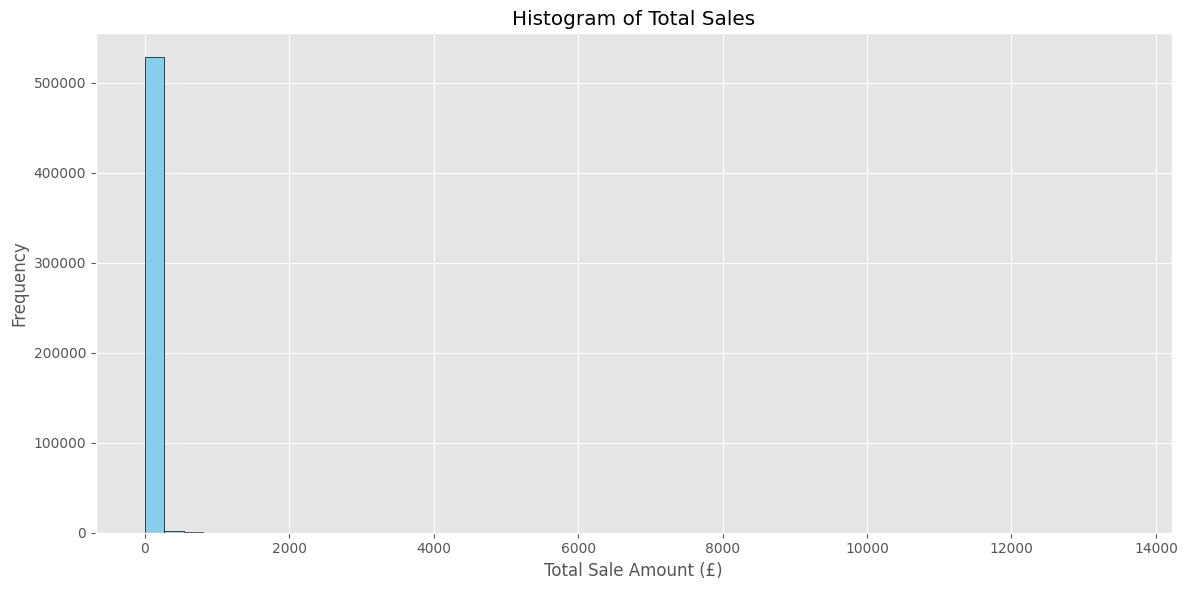

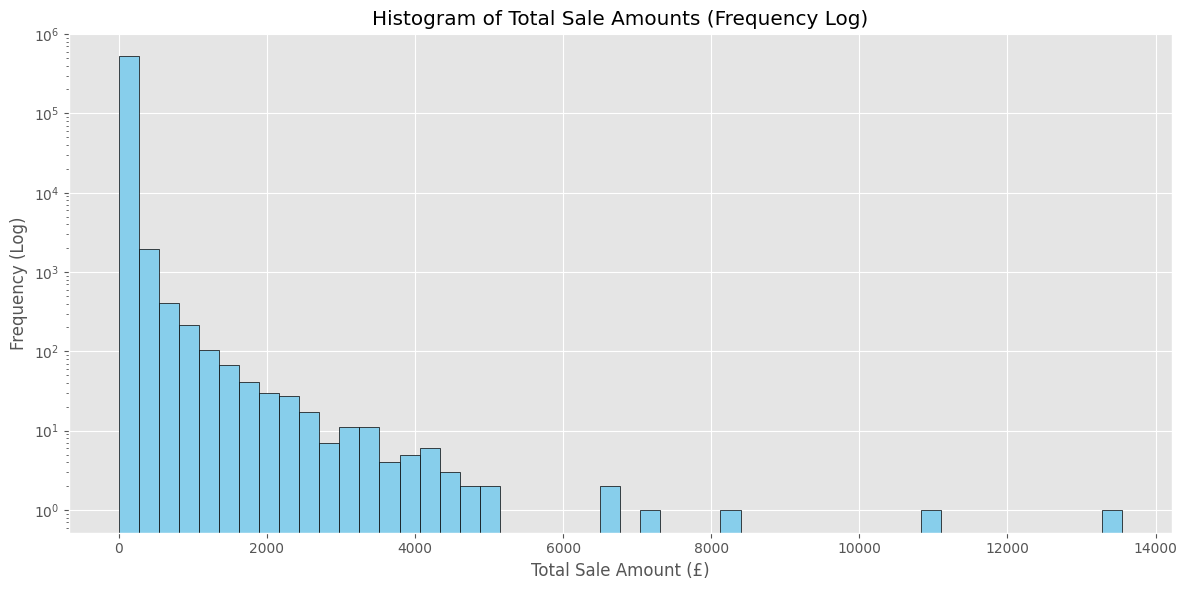

In [16]:
#filter by total using sales_df
total_sales = sales_df['total']

#unfiltered Total Sales Histogram
plt.figure(figsize=(12,6))
n,bins,patches = plt.hist(total_sales,bins=50,color="skyblue",edgecolor='black')
plt.title("Histogram of Total Sales")
plt.xlabel("Total Sale Amount (£)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#yscale (Frequency logged) Total Sales Histogram
plt.figure(figsize=(12, 6))
n,bins,patches = plt.hist(total_sales, bins=50, color='skyblue', edgecolor='black')
plt.yscale('log')
plt.title('Histogram of Total Sale Amounts (Frequency Log)')
plt.xlabel('Total Sale Amount (£)')
plt.ylabel('Frequency (Log)')
plt.tight_layout()
plt.show()


In [17]:
print(total_sales.describe())

count   531173.00
mean        19.54
std         73.89
min          0.00
25%          3.75
50%          9.90
75%         17.70
max      13541.33
Name: total, dtype: float64


Considering that the Q3 of my total sales dataframe is 17.70 (£), I will calculate a price point that captures the majority of my dataset (>90%) and still has a low number of bins for easier visualisation. 

In [18]:
percentile = (total_sales <= 50).mean() * 100
print(f"£50 corresponds to the {percentile:.2f}th percentile of your data.")


£50 corresponds to the 94.15th percentile of your data.


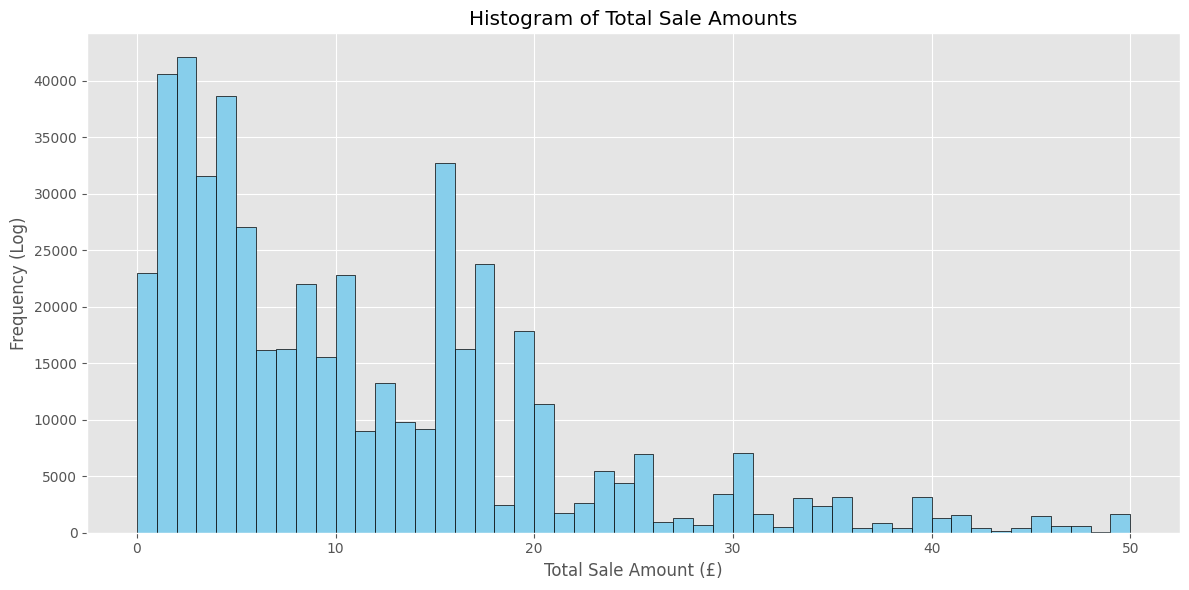

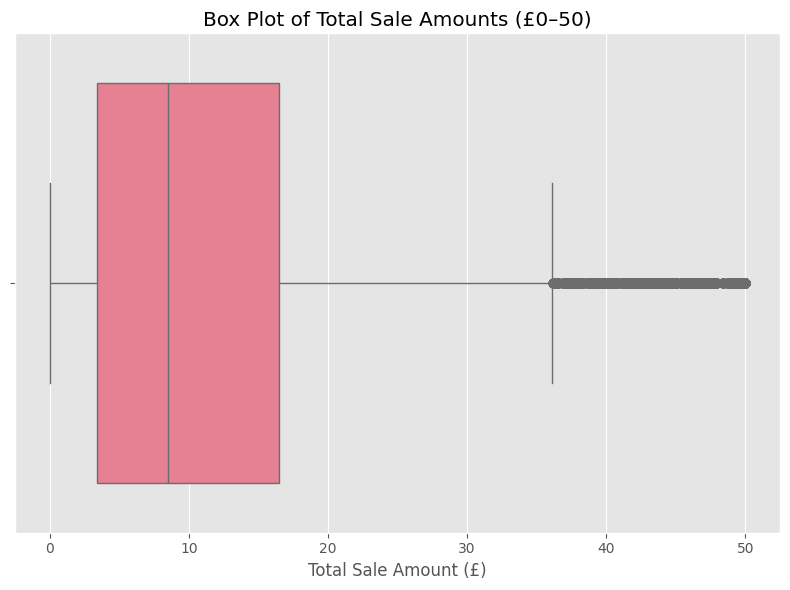

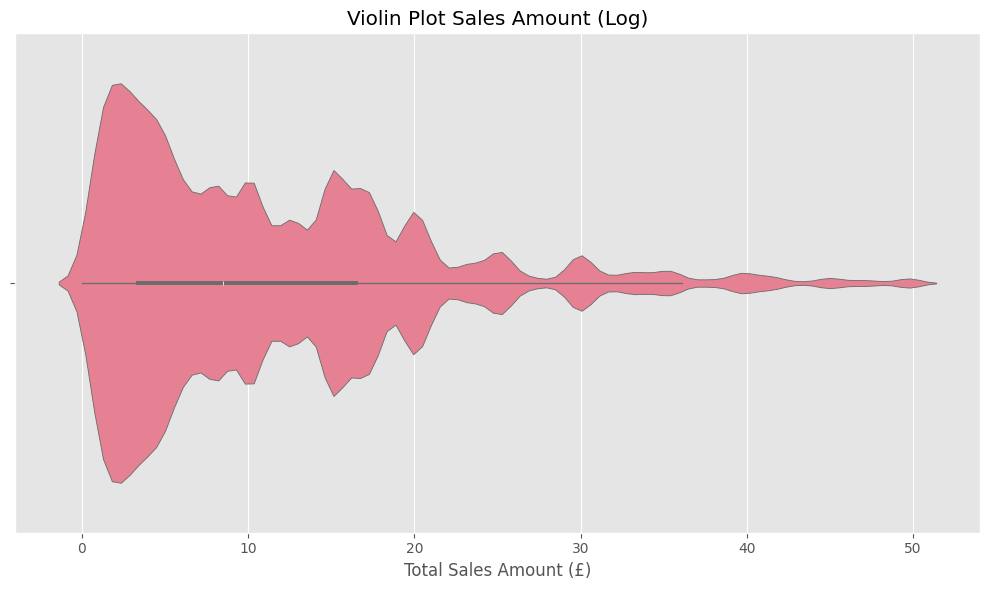

In [ ]:
# Filter total sales for the range 0-50
total_sales_0_50 = total_sales[(total_sales >= 0) & (total_sales <= 50)]

#histogram 
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(total_sales_0_50, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Total Sale Amounts (£0-50)')
plt.xlabel('Total Sale Amount (£)')
plt.ylabel('Frequency (Log)')
plt.tight_layout()
plt.show()

#boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=total_sales_0_50)
plt.title('Box Plot of Total Sale Amounts (£0-50)')
plt.xlabel('Total Sale Amount (£)')
plt.tight_layout()
plt.show()

#violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=total_sales_0_50)
plt.title('Violin Plot Total Sales Amount (£0-50)')
plt.xlabel('Total Sales Amount (£)')
plt.tight_layout()
plt.show()

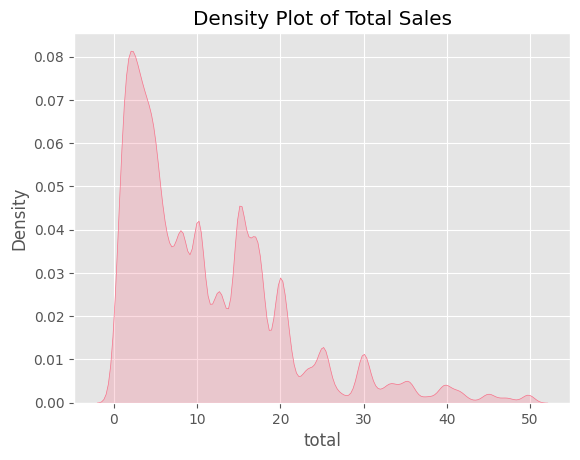

In [20]:
#KDE plot
sns.kdeplot(total_sales_0_50, fill=True)
plt.title('Density Plot of Total Sales')
plt.show()


This KDE graph demonstrates an interesting pattern that might be useful for businesses.
There are spikes in specific total sales ranges that customers most commonly spent. £10, £15, £20, £25, £30, £35, £40, £45, and £50 all show spikes in total expenditure by clients.
It is also clear that after these values there are drops in total sales by customers, for example values such as £19, £22, £27, £37, etc  

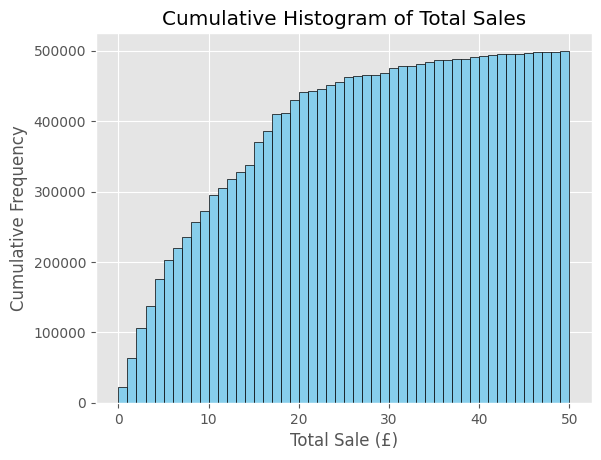

In [21]:
plt.hist(total_sales_0_50, bins=50, cumulative=True, color='skyblue', edgecolor='black')
plt.title("Cumulative Histogram of Total Sales")
plt.xlabel("Total Sale (£)")
plt.ylabel("Cumulative Frequency")
plt.show()


In [22]:
percentiles = total_sales.quantile([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])
print(percentiles)


0.01     0.42
0.10     1.66
0.25     3.75
0.50     9.90
0.75    17.70
0.90    32.60
0.99   183.60
Name: total, dtype: float64


3.2.2. Total Returns Analysis

In [26]:
#Calculate the absolute value of total returns 
total_returns = abs(return_df['total'])

#understand the statistical distribution of total returns
print(total_returns.describe())

count   10621.00
mean       57.64
std       516.99
min         0.00
25%         2.10
50%         6.80
75%        15.95
max     17836.46
Name: total, dtype: float64


In [27]:
#evaluate if 0-50 range can also be applied to the total return visualisations
percentile_ret = (total_returns <= 50).mean() * 100
print(f"£50 corresponds to the {percentile_ret:.2f}th percentile of your data.")


£50 corresponds to the 90.95th percentile of your data.


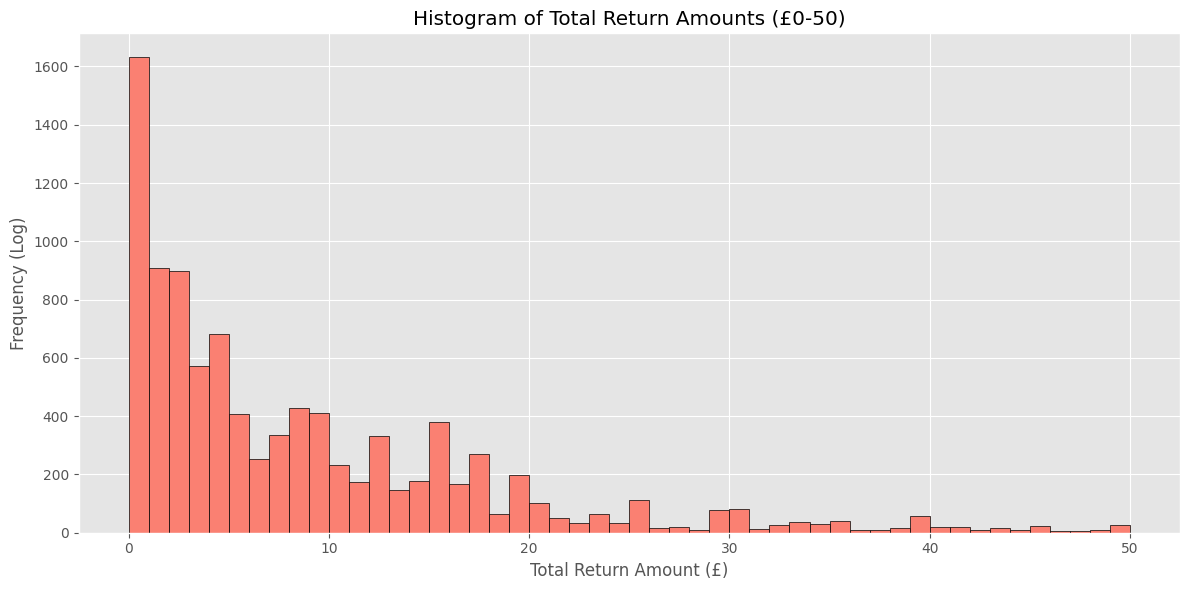

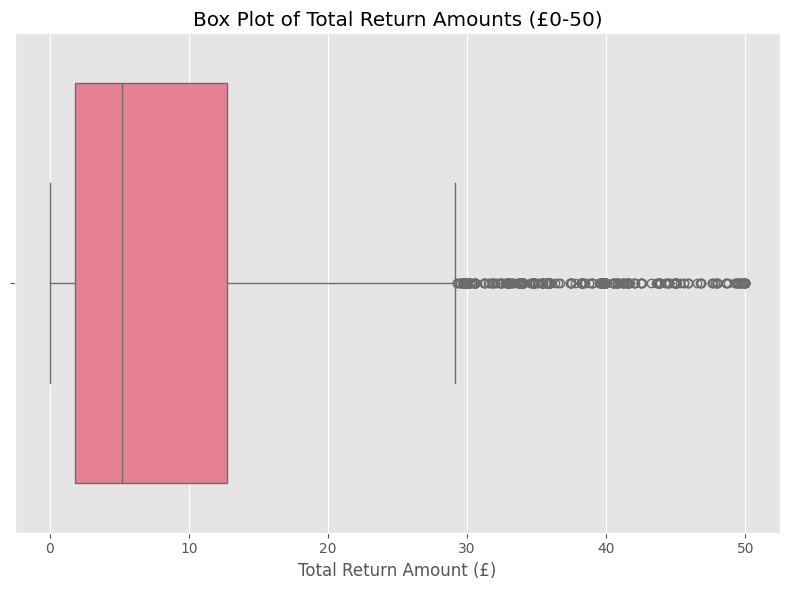

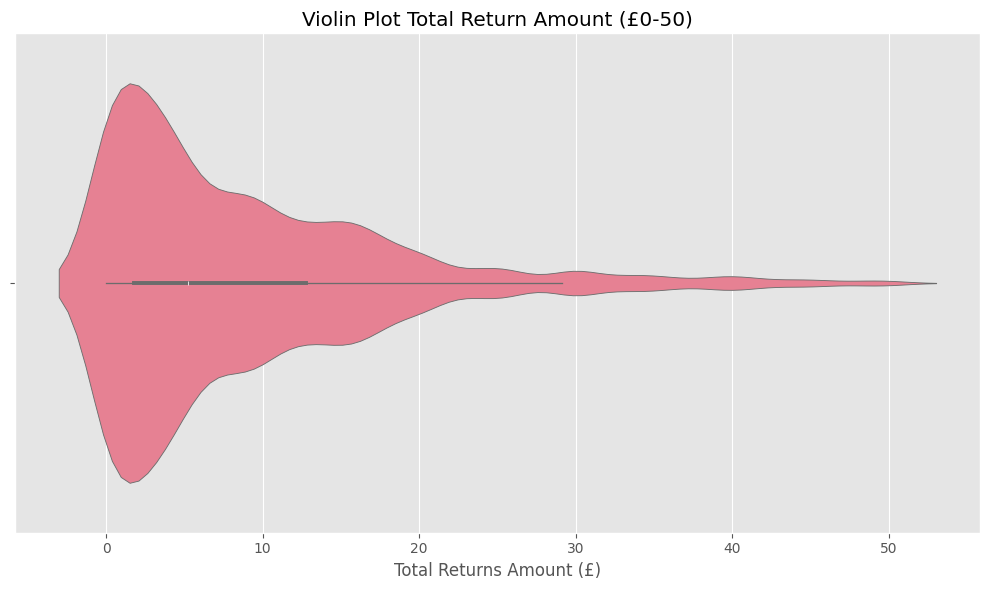

In [28]:
#lets calculate the 0-50 range of returns
total_returns_0_50 = total_returns[(total_returns >= 0) & (total_returns <= 50)]

plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(total_returns_0_50, bins=50, color='salmon', edgecolor='black')

#histogram
plt.title('Histogram of Total Return Amounts (£0-50)')
plt.xlabel('Total Return Amount (£)')
plt.ylabel('Frequency (Log)')
plt.tight_layout()
plt.show()

#boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x=total_returns_0_50)
plt.title('Box Plot of Total Return Amounts (£0-50)')
plt.xlabel('Total Return Amount (£)')
plt.tight_layout()
plt.show()

#violin pLot
plt.figure(figsize=(10,6))
sns.violinplot(x=total_returns_0_50)
plt.title('Violin Plot Total Return Amount (£0-50)')
plt.xlabel('Total Returns Amount (£)')
plt.tight_layout()
plt.show()


In [20]:
print("\nInvoice Analysis:")
print("Unique Invoices:")
print(df['invoice_no'].nunique())

inv_avg_sales = sales_df.groupby('invoice_no').size().mean()
print(f"Average number of sales per invoice: {inv_avg_sales:.2f}")

inv_avg_returns = return_df.groupby('invoice_no').size().mean()
print(f"Average number of returns per invoice: {inv_avg_returns:.2f}")

sales_customer = sales_df[sales_df["user_type"] == 'customer'] 
inv_avg_sale_per_customer = sales_customer.groupby('customer_id')['invoice_no'].nunique().mean()
print(f"Average number of unique sales invoices per customers: {inv_avg_sale_per_customer:.2f}")

returns_customer= return_df[return_df["user_type"] == 'customer']
inv_avg_ret_per_customer = returns_customer.groupby('customer_id')['invoice_no'].nunique().mean()
print(f"Average number of unique returns invoices per customers: {inv_avg_ret_per_customer:.2f}")




Invoice Analysis:
Unique Invoices:
25892
Average number of sales per invoice: 25.63
Average number of returns per invoice: 2.05
Average number of unique sales invoices per customers: 4.27
Average number of unique returns invoices per customers: 2.30
